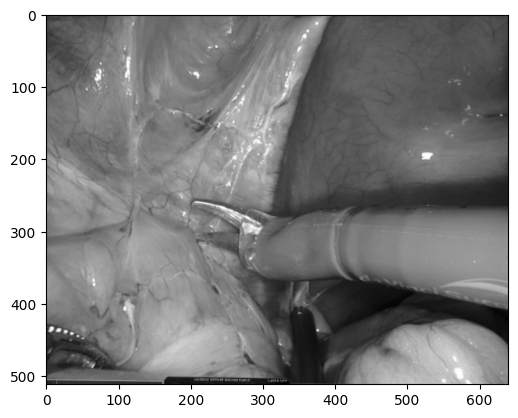

In [24]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
img = cv2.imread('data/endonerf_cutting/images/frame-000000.color.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img,cmap='gray')



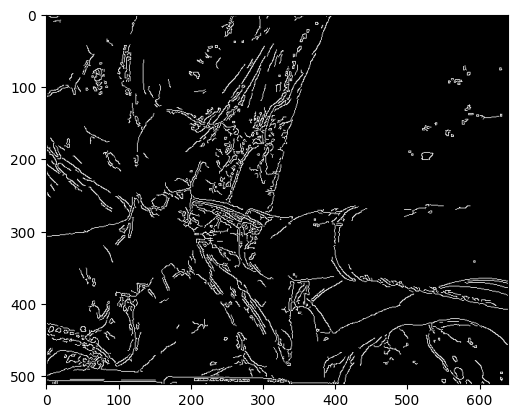

In [38]:
edges = cv2.Canny(img,50,100)
plt.imshow(edges,cmap='gray')
plt.show()

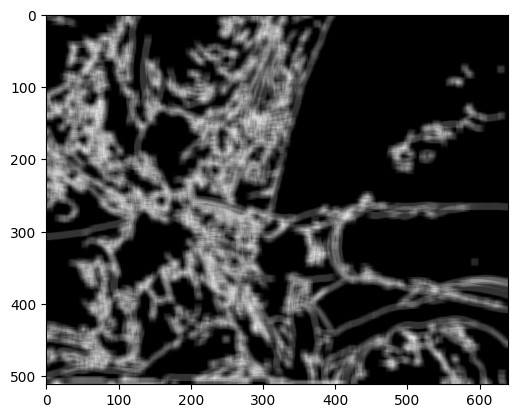

In [13]:
blur = cv2.blur(edges,(10,10))
plt.imshow(blur,cmap='gray')
plt.show()

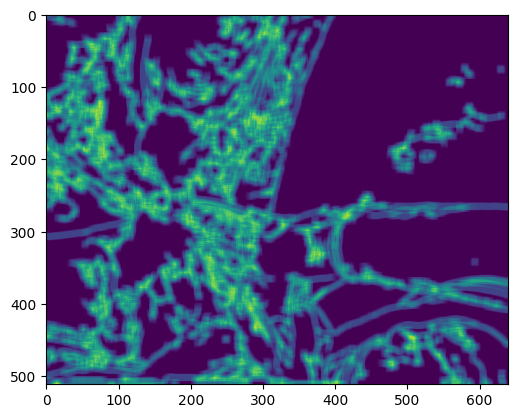

In [22]:
blur_norm = (blur-blur.min())/(blur.max()-blur.min())
plt.imshow(blur_norm)
plt.show()

In [33]:
blur_norm.max()

1.0

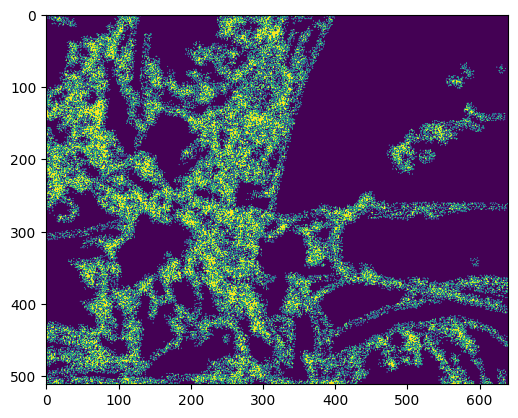

In [40]:
blur_norm_prob = blur_norm+np.random.uniform(0,1,blur_norm.shape)
plt.imshow(blur_norm_prob>1)